In [1]:
import pandas as pd
import pickle
import optuna
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.head()

,clean_comment,category
0,"film absolutely awful, but nevertheless, hilar...",0
1,well since seeing part 1 3 honestly say never ...,0
2,got see film preview dazzled it. not typical r...,1
3,adaptation positively butcher classic beloved ...,0
4,rzone awful movie! simple. seems tried make mo...,0


In [3]:
df = df.dropna(subset=['category'])

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_comment'],
    df['category'],
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

In [4]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [5]:
smote = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

In [6]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-08-14 14:42:42,354] A new study created in memory with name: no-name-93e74e5b-3e8b-4364-800a-e6c1de306ade
[I 2025-08-14 14:42:46,321] Trial 0 finished with value: 0.8407950210801044 and parameters: {'n_estimators': 260, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8407950210801044.
[I 2025-08-14 14:42:50,434] Trial 1 finished with value: 0.8430034129692833 and parameters: {'n_estimators': 145, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8430034129692833.
[I 2025-08-14 14:43:02,952] Trial 2 finished with value: 0.8488255370407549 and parameters: {'n_estimators': 255, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8488255370407549.
[I 2025-08-14 14:43:09,533] Trial 3 finished with value: 0.8424011242722345 and parameters: {'n_estimators': 218, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value

In [7]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

best_model = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train_vec, y_train)
y_pred = best_model.predict(X_test_vec)

Best Hyperparameters: {'n_estimators': 193, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 1}


In [8]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

Accuracy: 0.8554507127082915

Classification Report:
               precision    recall  f1-score   support

    Negative       0.87      0.84      0.85      2486
    Positive       0.84      0.87      0.86      2495

    accuracy                           0.86      4981
   macro avg       0.86      0.86      0.86      4981
weighted avg       0.86      0.86      0.86      4981



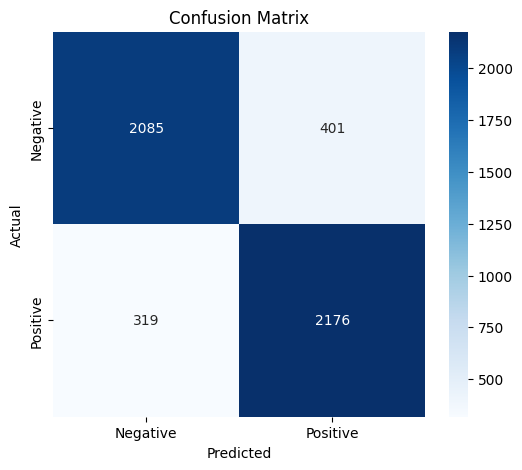

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()